### **Text Analysis of Patients' Opinions on HIV Services**

#### Research Problem
To understand the factors that influence service satisfaction in healthcare facilities and how patient feedback can be leveraged to improve service quality.

#### Research Questions
1. What themes are prevalent in the positive feedback provided by the patients?
1. What common issues are mentioned in the suggestions for improvement?
1. How does the sentiment of the feedback correlate with the reported service satisfaction?
1. Can we predict the level of service satisfaction based on the feedback provided?

#### Dataset Description
This dataset comprises of responses from patients receiving care/treatment at various healthcare centres in Kenya. It consists of over 40,000 responses.

This dataset is a subset of a survey that was conducted by PEPFAR and WOFAK between 2022-2023. The survey consists of questions to collect patient feedback on their satisfaction of HIV services. The selected columns to be used in this analysis are outlined below:

1. SurveyID - the ID column
1. FacilityCounty - the county where the facility is located
1. FacilityLevel - the facility level
1. ServicesLiked - opinion of the services the patient liked
1. ServicesDisliked - opinion of the services the patient did not like
1. ImprovementSuggestions - opinion on the services the patient would like to be improved
1. AccessImprovementSuggestions - opinion on what the patient would like to be improved on accessing the facilities
1. PositiveObservations - opinion of the services the patient liked that can be emulated by other facilities
1. GeneralImprovementSuggestions - opinion on what the patient would like to be improved
1. AdditionalComments - any other comment not related to the questions above
1. TopFacilityFeatures - what the patient liked in regards to care and treatment

This notebook outlines an NLP project aimed at analyzing service feedback to improve quality and efficiency.

Problem Statement: The need to extract meaningful insights from unstructured service feedback to enhance service quality.

Justification: Efficient analysis of feedback can help prioritize areas needing improvement and recognize strengths.

Assumptions: Feedback is honest and provided in English.

Scope: Analysis will cover sentiment analysis, topic modeling, and summarization of the feedback.

Hypothesis: Negative feedback correlates strongly with suggestions for improvement and can be used to drive specific changes.

### **Import Dependencies**

In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import plotly.express as px

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mogam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mogam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mogam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Load data
data = pd.read_csv("data/clm_open_ended.csv")
data.head()

,Date of feedback collection,County,Positive feedback on services,Negative feedback on services,Suggestions for improving access to services,Positive aspects of facility to emulate,General suggestions for improvement,Top 1-3 Positive aspects of care and treatment,Top 1-3 Negative aspects of care and treatment
0,2024-04-17 20:55:46,Narok,Good,NaN,To used hospital,Good services,Time,Awareness,NaN
1,2024-04-17 19:49:25,Kisumu,Quick service delivery,NaN,Additional of medics to speed service delivery,Medics talk well to clients,NaN,Quick service delivery,NaN
2,2024-04-17 19:44:28,Kisumu,Got drugs and happy,NaN,NaN,Good treatment services,NaN,Got drugs and happy.,NaN
3,2024-04-17 19:37:41,Kisumu,Quick service delivery,NaN,NaN,Good medication services,Infrastructure development and add machines to...,Quick service delivery,NaN
4,2024-04-17 19:31:12,Kisumu,Good reception from medics,NaN,NaN,Medics are patient and have good listening ear...,Quick service delivery,Good reception from medics,NaN


#### Data Cleaning and Preprocessing

In [4]:
print("Data shape: ", data.shape)

Data shape:  (60749, 9)


In [5]:
data.drop(['Date of feedback collection', 'County'], axis=1, inplace=True)

In [6]:
data = data.drop_duplicates()

In [7]:
print("Data shape: ", data.shape)

Data shape:  (49072, 7)


In [8]:
print("Missing values in each column:")
print(data.isnull().sum())

Missing values in each column:
Positive feedback on services                       375
Negative feedback on services                      7748
Suggestions for improving access to services       5207
Positive aspects of facility to emulate            1404
General suggestions for improvement                6383
Top 1-3 Positive aspects of care and treatment     2575
Top 1-3 Negative aspects of care and treatment    30856
dtype: int64


In [9]:
data.fillna('', inplace=True)
# data.drop(['Suggestions for improving access to services', 'Positive aspects of facility to emulate', 'General suggestions for improvement', 'Top 1-3 Positive aspects of care and treatment', 'Top 1-3 Negative aspects of care and treatment'], axis=1, inplace=True)

In [10]:
print("Missing values in each column:")
print(data.isnull().sum())

Missing values in each column:
Positive feedback on services                     0
Negative feedback on services                     0
Suggestions for improving access to services      0
Positive aspects of facility to emulate           0
General suggestions for improvement               0
Top 1-3 Positive aspects of care and treatment    0
Top 1-3 Negative aspects of care and treatment    0
dtype: int64


In [11]:
data.shape

(49072, 7)

In [12]:
data['positive_feedback'] = data[['Positive feedback on services', 'Top 1-3 Positive aspects of care and treatment']].agg('. '.join, axis=1)
data['negative_feedback'] = data[['Negative feedback on services', 'Top 1-3 Negative aspects of care and treatment']].agg('. '.join, axis=1)
data['improvement_suggestions'] = data[['Suggestions for improving access to services', 'Positive aspects of facility to emulate', 'General suggestions for improvement']].agg('. '.join, axis=1)
data.drop(['Positive feedback on services', 'Negative feedback on services', 'Suggestions for improving access to services', 'Positive aspects of facility to emulate', 'General suggestions for improvement', 'Top 1-3 Positive aspects of care and treatment', 'Top 1-3 Negative aspects of care and treatment'], axis=1, inplace=True)

In [14]:
# Data preprocessing using tokenization, normalizaiton, removal of stopwords, and lemmatization
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    stop_words = set(stopwords.words('english'))
    other_stop = ['service', 'nan', 'nothing', 'comment', 'comments', 'none', 'non', 'plumpy', 'nut', 'ok', 'okay']
    extended_stop_words = stop_words.union(other_stop)
    tokens = [token for token in tokens if token not in extended_stop_words and token.isalpha()]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

text_columns = ['positive_feedback', 'negative_feedback', 'improvement_suggestions']
for column in text_columns:
    data[column] = data[column].astype(str).apply(preprocess_text)

### **Exploratory Data Analysis**

#### WordCloud Generation

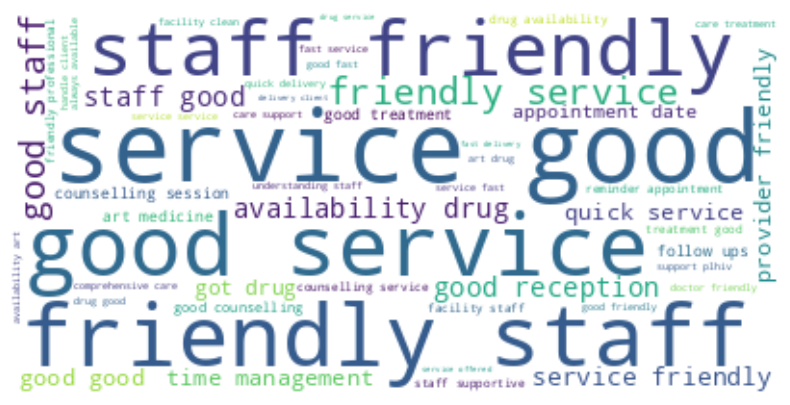

In [ ]:
# Generate a word cloud for the 'positive_feedback' column
text = ' '.join(data['positive_feedback'].dropna())
wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

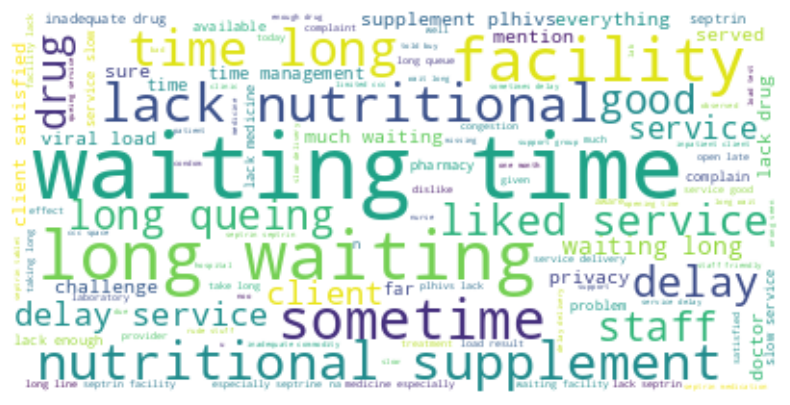

In [ ]:
# Generate a word cloud for the 'negative_feedback' column
text = ' '.join(data['negative_feedback'].dropna())
wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

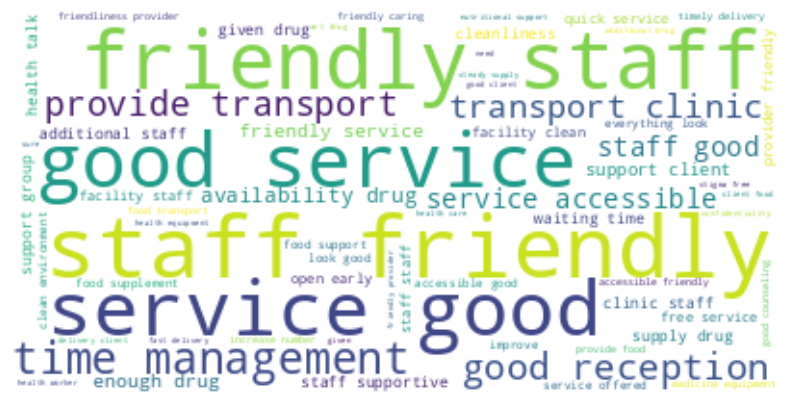

In [ ]:
# Generate a word cloud for the 'negative_feedback' column
text = ' '.join(data['improvement_suggestions'].dropna())
wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### LDA Analysis

In [ ]:
tokenized_docs = [word_tokenize(doc) for doc in data['positive_feedback']]
dictionary = corpora.Dictionary(tokenized_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

num_topics = 5
passes = 15
iterations = 400

lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, iterations=iterations)

vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

Topic 1 - "service," "good," "friendly," "staff," "free," are significant for this topic

In [ ]:
tokenized_docs = [word_tokenize(doc) for doc in data['negative_feedback']]
dictionary = corpora.Dictionary(tokenized_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

num_topics = 5
passes = 15
iterations = 400

lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, iterations=iterations)

vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

Topic 1 - "service," "good," "friendly," "staff," "free," are significant for this topic

In [ ]:
tokenized_docs = [word_tokenize(doc) for doc in data['improvement_suggestions']]
dictionary = corpora.Dictionary(tokenized_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

num_topics = 5
passes = 15
iterations = 400

lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, iterations=iterations)

vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

Topic 1 - "service," "good," "friendly," "staff," "free," are significant for this topic

### **Predictive Analysis**

In [15]:
feedback_types = {
    'positive_feedback': {
        'FriendlyStaff': 'friendly staff',
        'CleanFacility': 'clean facility',
        'GoodCare': 'good care',
        'Drugs': 'drugs available'
    },
    'negative_feedback': {
        'LongWait': 'long wait',
        'PoorCare': 'poor care',
        'RudeStaff': 'rude staff',
    },
    'improvement_suggestions': {
        'MoreStaff': 'more staff',
        'BetterFacilities': 'better equipment',
        'ShorterWaitTimes': 'shorter wait times'
    }
}

# Create binary flags for each phrase in each feedback type
for feedback_column, phrases in feedback_types.items():
    for col, phrase in phrases.items():
        data[col] = data[feedback_column].str.lower().apply(lambda x: 1 if phrase in x else 0)

In [16]:
def train_and_evaluate(data, feature_col, label_col):
    # Vectorize the feedback
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(data[feature_col])
    y = data[label_col]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Naive Bayes classifier
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Predict and evaluate the model
    y_pred = model.predict(X_test)
    print(f"Classification report for {label_col}:")
    print(classification_report(y_test, y_pred))

# Train and evaluate models for each feedback type and phrase
for feedback_column, phrases in feedback_types.items():
    for col in phrases:
        train_and_evaluate(data, feedback_column, col)

Classification report for FriendlyStaff:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      8854
           1       0.87      0.12      0.21       961

    accuracy                           0.91      9815
   macro avg       0.89      0.56      0.58      9815
weighted avg       0.91      0.91      0.88      9815

Classification report for CleanFacility:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9782
           1       0.00      0.00      0.00        33

    accuracy                           1.00      9815
   macro avg       0.50      0.50      0.50      9815
weighted avg       0.99      1.00      0.99      9815



c:\Users\mogam\Desktop\MScDSA\Module 5\TUDA\mod5_tuda\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mogam\Desktop\MScDSA\Module 5\TUDA\mod5_tuda\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mogam\Desktop\MScDSA\Module 5\TUDA\mod5_tuda\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Classification report for GoodCare:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9771
           1       0.00      0.00      0.00        44

    accuracy                           1.00      9815
   macro avg       0.50      0.50      0.50      9815
weighted avg       0.99      1.00      0.99      9815



c:\Users\mogam\Desktop\MScDSA\Module 5\TUDA\mod5_tuda\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mogam\Desktop\MScDSA\Module 5\TUDA\mod5_tuda\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mogam\Desktop\MScDSA\Module 5\TUDA\mod5_tuda\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Classification report for Drugs:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9815

    accuracy                           1.00      9815
   macro avg       1.00      1.00      1.00      9815
weighted avg       1.00      1.00      1.00      9815

Classification report for LongWait:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9716
           1       0.00      0.00      0.00        99

    accuracy                           0.99      9815
   macro avg       0.49      0.50      0.50      9815
weighted avg       0.98      0.99      0.98      9815



c:\Users\mogam\Desktop\MScDSA\Module 5\TUDA\mod5_tuda\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mogam\Desktop\MScDSA\Module 5\TUDA\mod5_tuda\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mogam\Desktop\MScDSA\Module 5\TUDA\mod5_tuda\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Classification report for PoorCare:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9815

    accuracy                           1.00      9815
   macro avg       1.00      1.00      1.00      9815
weighted avg       1.00      1.00      1.00      9815

Classification report for RudeStaff:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9807
           1       0.00      0.00      0.00         8

    accuracy                           1.00      9815
   macro avg       0.50      0.50      0.50      9815
weighted avg       1.00      1.00      1.00      9815



c:\Users\mogam\Desktop\MScDSA\Module 5\TUDA\mod5_tuda\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mogam\Desktop\MScDSA\Module 5\TUDA\mod5_tuda\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mogam\Desktop\MScDSA\Module 5\TUDA\mod5_tuda\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Classification report for MoreStaff:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9815

    accuracy                           1.00      9815
   macro avg       1.00      1.00      1.00      9815
weighted avg       1.00      1.00      1.00      9815

Classification report for BetterFacilities:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9807
           1       0.00      0.00      0.00         8

    accuracy                           1.00      9815
   macro avg       0.50      0.50      0.50      9815
weighted avg       1.00      1.00      1.00      9815



c:\Users\mogam\Desktop\MScDSA\Module 5\TUDA\mod5_tuda\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mogam\Desktop\MScDSA\Module 5\TUDA\mod5_tuda\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mogam\Desktop\MScDSA\Module 5\TUDA\mod5_tuda\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Classification report for ShorterWaitTimes:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9815

    accuracy                           1.00      9815
   macro avg       1.00      1.00      1.00      9815
weighted avg       1.00      1.00      1.00      9815

